<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraries and Utilities</h3>


In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import networkx          as nx
import seaborn           as sns
from nltk                import ngrams
from pyvis.network       import Network
import os
import re
import nltk
import pydot
import spacy as sp
import pickle
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import STOPWORDS
from string import punctuation
import enchant
import pickle
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
wchecker = enchant.Dict("en_US")
nlps = sp.load('en_core_web_sm')

In [733]:
class BiGramGraph:
    """
    A class used to transform a corpus given as a numpy array into a graph form of the
    2-gram representation.

    ...

    Attributes
    ----------
    Graph : nx.Graph
        The Graph Representation of The Ngram Input.
    N_nodes : int
        Number of Nodes in Graph.
    N_edges : int
        Number of Edges in Graph.
    In_Max_Deg : int
        Maximum In Degree in Graph.
    Out_Max_Deg : int
        Maximum Out Degree in Graph.
    In_Min_Deg : int
        Minimum In Degree in Graph.
    Out_Min_Deg : int
        Minimum Out Degree in Graph.

    Methods
    -------
    Example_Method(arg=None)
        Add info
    """

    def __init__(self, data=None,prebuild=None, notebook=False):
        if prebuild != None:
                self.Graph        = prebuild[0]
                self.N_nodes      = prebuild[1]
                self.N_edges      = prebuild[2]
                self.In_Max_Deg   = prebuild[3]
                self.Out_Max_Deg  = prebuild[4]
                self.In_Min_Deg   = prebuild[5]
                self.Out_Min_Deg  = prebuild[6]
                self.Data         = prebuild[7]
                self.Name         = prebuild[8]
                self.Edges        = prebuild[9]
        else:
            if not notebook:
                from tqdm import tqdm
                tqdm.pandas()
            else:
                from tqdm.notebook import tqdm
                tqdm.pandas()
            
            #merge text into a singal body and calculate bigram 
            tokenized_text = ' '.join(data).split()
            ngram = ngrams(tokenized_text, n=2)
            ngram = list(ngram)
            
            #derive edge weights an unique words to be represented as nodes
            n_frequencies = nltk.FreqDist(ngram)
            edges = list(dict(n_frequencies).keys())
            nodes = np.unique(np.array(edges).flatten())
            
            #initiate an instance of a directed graph  
            self.Graph = nx.DiGraph()
            self.Graph.add_nodes_from(nodes)
            #Set graph edges according to bigram pairs
            for x, y in edges:
                self.Graph.add_edge(x, y, value=n_frequencies[(x, y)])
            

            # ===================Graph Attributes ==============================
            self.N_nodes = len(nodes)
            self.N_edges = len(edges)
            self.In_Max_Deg = max(dict(self.Graph.in_degree).values())
            self.Out_Max_Deg = max(dict(self.Graph.out_degree).values())
            self.In_Min_Deg = min(dict(self.Graph.in_degree).values())
            self.Out_Min_Deg = min(dict(self.Graph.out_degree).values())
            self._nlp = None
            self.Data = nx.algorithms.coloring.greedy_color(self.Graph)
            self.Data = pd.DataFrame([self.Data.values(),
                                      self.Data.keys()]).T.rename(columns={0: 'color', 1: 'word'})
            self.Name='Default Name'

            self.Edges = pd.DataFrame(edges, columns=['in', 'out'])
            self.Edges['weight'] = self.Edges.apply(lambda _z: n_frequencies[(_z['in'], _z['out'])], axis=1)
            # =================================================================
            
            
    def add_part_of_speech(self):
        """
        Use spacy to extract part of speech tag for each node and append it to the "Data" attribute.
        """
        import spacy as sp
        self._nlp = sp.load('en_core_web_sm')
        self.Data['pos'] = self.Data['word'].progress_apply(lambda _z: self._nlp(str(_z))[0].pos_)
        
    def add_entities_of_speech(self):
        """
        Use spacy to extract part of speech tag for each node and append it to the "Data" attribute.
        """
        import spacy as sp
        self._nlp = sp.load('en_core_web_sm')
        def get_ent(_z):
            t = self._nlp(str(_z)).ents
            if len(t)>0:
                return t[0].label_
            else:
                return 'NaN'
        self.Data['ent'] = self.Data['word'].progress_apply(get_ent)

    def get_Xi(self) -> int:
        """
        :return: The chromatic number of the graph.
        """
        return len(self.Data['color'].unique())
    
    def is_DAG(self):
        """
        Check if a BiGramGraph represent a directed acyclic graph
        return: Boolean: True if the graph is DAG else False
        """
        return nx.algorithms.dag.is_directed_acyclic_graph(self.Graph)
    def get_Diameter(self):
        """
        Returns the diameter of the graph
        return: Int: Diameter of the graph
        """
        return nx.algorithms.distance_measures.diameter(self.Graph)
    
    def get_Min_Edge_Cover(self):
        """
        Returns the minimum edge cover of the graph
        return: 
        """
        return nx.algorithms.covering.min_edge_cover(self.Graph)
    
    def get_Shortest_Simple_Path(self,start_node,end_node):
        return nx.algorithms.simple_paths.shortest_simple_paths(self.Graph,source=start_node,target=end_node)
    
    def get_Eulerian(self):
        if nx.is_eulerian(self.Graph):
            return nx.eulerian_circuit()(self.Graph)
        else:
            return 'Not Eulerian'
        
    def get_Volume(self,S):
        return nx.algorithms.cuts.volume(self.Graph,S)
        
    def get_Eulerian_Path(self):
        return nx.eulerian_path(self.Graph) if nx.has_eulerian_path(self.Graph) else "Graph Has No Eulerian Path"
        
    def get_Cycle(self,start_node):
        return nx.algorithms.cycles.find_cycle(self.Graph,start_node)
    
    def get_All_Unique_Cycles(self):
        """
        Returns all unique simple cycles contained inside the graph
        return: List of list where each inner list contains a sequence of nodes representing a cycle
        """
        hash_list = []
        unique_cycle = []
        for i in tqdm(range(self.N_nodes),leave=False):
            cyclye = self.get_Cycle(self.Data.word[i])
            c_hash = hash(str(self.get_Cycle(self.Data.word[i])))
            if c_hash not in hash_list:
                hash_list.append(c_hash)
                unique_cycle.append(cyclye)
        return unique_cycle
    def get_All_Simple_Cycles(self):
        """
        Returns a generator which output simple cycles 
        return: A generator of cycles
        """
        return nx.algorithms.cycles.simple_cycles(self.Graph)
    
    def get_Shortest_Path(self,source,target,weight=None,method='dijkstra'):
        return nx.shortest_path(bigraph_models[0].Graph, source=source, target=target, weight=weight, method=method)
    
    def is_Strongly_Connected(self):
        return nx.algorithms.components.is_strongly_connected(self.Graph)
    def get_Number_Strongly_Connected_Components(self):
        return nx.algorithms.components.number_strongly_connected_components(self.Graph)
    def get_Strongly_Connected_Components(self):
        return nx.algorithms.components.strongly_connected_components(self.Graph)
    def remove_self_loops(self):
        self.Graph.remove_edges_from(nx.selfloop_edges(self.Graph))
    def extract_K_Core(self,K=None,notebook=False):
        K_CORE = nx.algorithms.core.k_core(self.Graph,k=K)
        attributes = []
        # ===================Graph Attributes ==============================
        attributes.append(K_CORE) #Graph
        attributes.append(K_CORE.number_of_nodes())
        attributes.append(K_CORE.number_of_edges())
        attributes.append(max(dict(K_CORE.in_degree).values()))
        attributes.append(max(dict(K_CORE.out_degree).values()))
        attributes.append(min(dict(K_CORE.in_degree).values()))
        attributes.append(min(dict(K_CORE.out_degree).values()))
        #Data = nx.algorithms.coloring.greedy_color(K_CORE)
        nodes = list(K_CORE.nodes())

        Data = self.Data.set_index('word').loc[nodes].reset_index()
        #Data['color'] = self.Data.set_index('word').loc[nodes].reset_index().color
        #Data = Data[['color','word']]
        attributes.append(Data)
        attributes.append(self.Name)
        
        weights = dict(K_CORE.edges)#[('empty','street')]['value']

        Edges = pd.DataFrame(list(weights.keys()), columns=['in', 'out'])

        Edges['weight'] = Edges.apply(lambda _z: weights[(_z['in'], _z['out'])]['value'], axis=1)
        attributes.append(Edges)
            # =================================================================
  

        return  BiGramGraph(prebuild=attributes,notebook=notebook)


    def __repr__(self):
        n = self.N_nodes
        e = self.N_edges
        xi = self.get_Xi()
        return f'Number of words included: {n}\nNumber of edges included: {e}\nChromatic number: {xi}\n'

    def __getitem__(self, item) -> dict:
        return dict()

    def vectorize(self, string, method='chromatic'):
        if method == 'chromatic':
            tokens = string.split(' ')
            vec_form = []
            for tok in tokens:
                if tok not in self.Data.word.values:
                    continue
                vec_form.append(self.Data.query(f'word == "{tok}"')['color'].values[0])
            return vec_form
        else:
            raise NameError('Bad Method')
            
    def dump(self):
        return [self.Graph,
                self.N_nodes,
                self.N_edges,
                self.In_Max_Deg,
                self.Out_Max_Deg,
                self.In_Min_Deg,
                self.Out_Min_Deg,
                self.Data,
                self.Name,
                self.Edges
               ]


    def Viz_Graph(self, notebook=False, height=500, width=900, directed=False):
        nt = Network(f'{height}px', f'{width}px', notebook=notebook, directed=directed)
        nt.set_options(
            'var options = { "physics": {"forceAtlas2Based": {"gravitationalConstant": -230,"springLength": 170,\
              "springConstant": 0,\
              "avoidOverlap": 1\
            },\
            "minVelocity": 0.75,\
            "solver": "forceAtlas2Based",\
            "timestep": 1\
          }\
        }\
        ')
        nt.from_nx(self.Graph)
        # nt.show_buttons(filter_=['physics'])
        nt.prep_notebook()
        return nt.show('nx.html')


In [734]:
#Utils

def calculate_path_weight(Graph,path):
    weight = 0
    start = path[0]
    for i in path[1:]:
        weight += Graph.Edges[(Graph.Edges['in'] == start[0])&(Graph.Edges.out == i[0])].weight.values[0]
        start =i
    return weight

def calculate_cycle_density(Graph,cycle):
    weight = 0
    for i in cycle:
        weight += np.sqrt(Graph.Graph.out_degree(i[0])+Graph.Graph.in_degree(i[0]))
    return weight    

def calculate_path_density(Graph,path):
    weight = 0
    for i in path:
        IN  = Graph.Graph.out_degree(i[0])
        OUT = Graph.Graph.in_degree(i[0])
        if type(IN)!=int:
            weight += np.sqrt(OUT)
        elif type(OUT) != int:
            weight += np.sqrt(IN)
        else:
            weight+= np.sqrt(IN+OUT)
    return weight 
    

<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Graph Attribute Exploration</h3>


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Chromatic Number</h3>


 
<h3 style="background-color:green;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Texts Dataset</h3>


In [735]:
def remove_punct(text):
    table=str.maketrans('','',punctuation)
    return text.translate(table)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def word_validation(text):
    words = text.split(' ')
    words = [i for i in words if wchecker.check(i) == True]
    return ' '.join(words)


In [736]:
#GLOVAL VARS

NFOLDER_PATH = '/Users/tomas/source/repos/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks'

In [737]:
multi_text = pd.read_parquet(NFOLDER_PATH+'/multi_text_ds_no_stopwords.parquet')

In [738]:
multi_text.head(3)

,airport_reviews,amazon_alexa_reviwes,Anime_synopsis,bible_text,children_books,elonmusk_tweets,GBA_Games_plot,hp1_movie_script,medium_articles,movie_synopsis,nirvana_lyrics,poe_stories,Restaurant_Reviews,rick_and_morty_script,slogans,ham_sms,Terminator3,Terminator2,Terminator1,Womens_Clothing_reviews
0,airport certainly tiny arriving good plane qui...,love echo,order something obtained something equal value...,11 beginning god created heaven earth,every year evil protectorate offers baby evil ...,band robots spared humanity,game opens agent bond infiltrates stronghold o...,chapter one boy lived,oh headlines blared next big thing hopes sky h...,ted bellhops first night hotels unusual guests...,need easy friend ear lend think fit shoe clue ...,ways god nature providence ways models frame w...,wow loved place,gotta come jus gotta come,never follow keeping ahead technology everyone...,go point crazy available great world la buffet...,downtown la noon hot summer day extreme long lens,start tight wright hes intense powerful man,ext schoolyard night 1,absolutely wonderful silky sexy comfortable
1,small airports generally intimate friendly wel...,NaN,seeking restore diminishing hope survey corps ...,None,anna struggling understand new boy school one ...,exactly tesla absurdly overvalued based past,agent bond works alongside french intelligence...,number four privet drive proud say perfectly n...,found looking question concept syntax programm...,racing boxing match frank mike john bargained ...,whats season love cant everything whats reason...,chance good lady hath bereft thus quiet still ...,crust good,rick going,company advertising campaigns byte apple late ...,lar joking,lunchtime crowd stacks wall humanity slow motion,head shaven stares camera,silence gradually sound distant traffic becomes,love dress pretty happened find store glad nev...
2,waited hour corridor baggage arrival 3 hours w...,sometimes playing game answer question correct...,mad scientist rents room rickety old building ...,12 earth without form void darkness upon,browns swimming ambitions sank without trace f...,None,None,director firm called made drills big beefy man...,machine learning increasingly moving models au...,labels new project experimental music document...,shame go shame shame go shame shame go got oh ...,passus de bristly bore let us hurry walls said...,tasty texture nasty,got surprise,new arriving nonstop know fly two great airlin...,None,move herds among glittering rows cars jammed b...,resigned expression hear voice priest,audible low angle bounded one side,high hopes dress really wanted work initially ...


In [739]:
# bigram_models = []

# for column in tqdm(multi_text.columns):
#     data = multi_text[column][multi_text[column].notna()]
#     G = BiGramGraph(data=data,notebook=True)
#     G.Name=column
#     G.add_part_of_speech()
#     bigram_models.append(G)

In [740]:
# #Save Models
# with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_text_model_list.pkl", "wb") as file:
#     pickle.dump([i.dump() for i in bigram_models],file)

In [753]:
# Load Pre Fitted Models
with open(NFOLDER_PATH+"/multi_text_model_list.pkl", "rb") as file:
    bigraph_models = [BiGramGraph(prebuild=attributes,notebook=True) for attributes in pickle.load(file)]

In [754]:
#try and remove self loops
for g in bigraph_models:
    g.remove_self_loops()
    #g.add_entities_of_speech()

In [778]:
for idx,graph in enumerate(bigraph_models):
    print(idx+1,') Dataset Name: [',graph.Name,']\n',graph,'\n','--'*20)

1 ) Dataset Name: [ airport_reviews ]
 Number of words included: 9231
Number of edges included: 108142
Chromatic number: 24
 
 ----------------------------------------
2 ) Dataset Name: [ amazon_alexa_reviwes ]
 Number of words included: 3420
Number of edges included: 22249
Chromatic number: 13
 
 ----------------------------------------
3 ) Dataset Name: [ Anime_synopsis ]
 Number of words included: 20835
Number of edges included: 289590
Chromatic number: 24
 
 ----------------------------------------
4 ) Dataset Name: [ bible_text ]
 Number of words included: 11741
Number of edges included: 195863
Chromatic number: 33
 
 ----------------------------------------
5 ) Dataset Name: [ children_books ]
 Number of words included: 1864
Number of edges included: 3249
Chromatic number: 4
 
 ----------------------------------------
6 ) Dataset Name: [ elonmusk_tweets ]
 Number of words included: 4927
Number of edges included: 18175
Chromatic number: 7
 
 ---------------------------------------

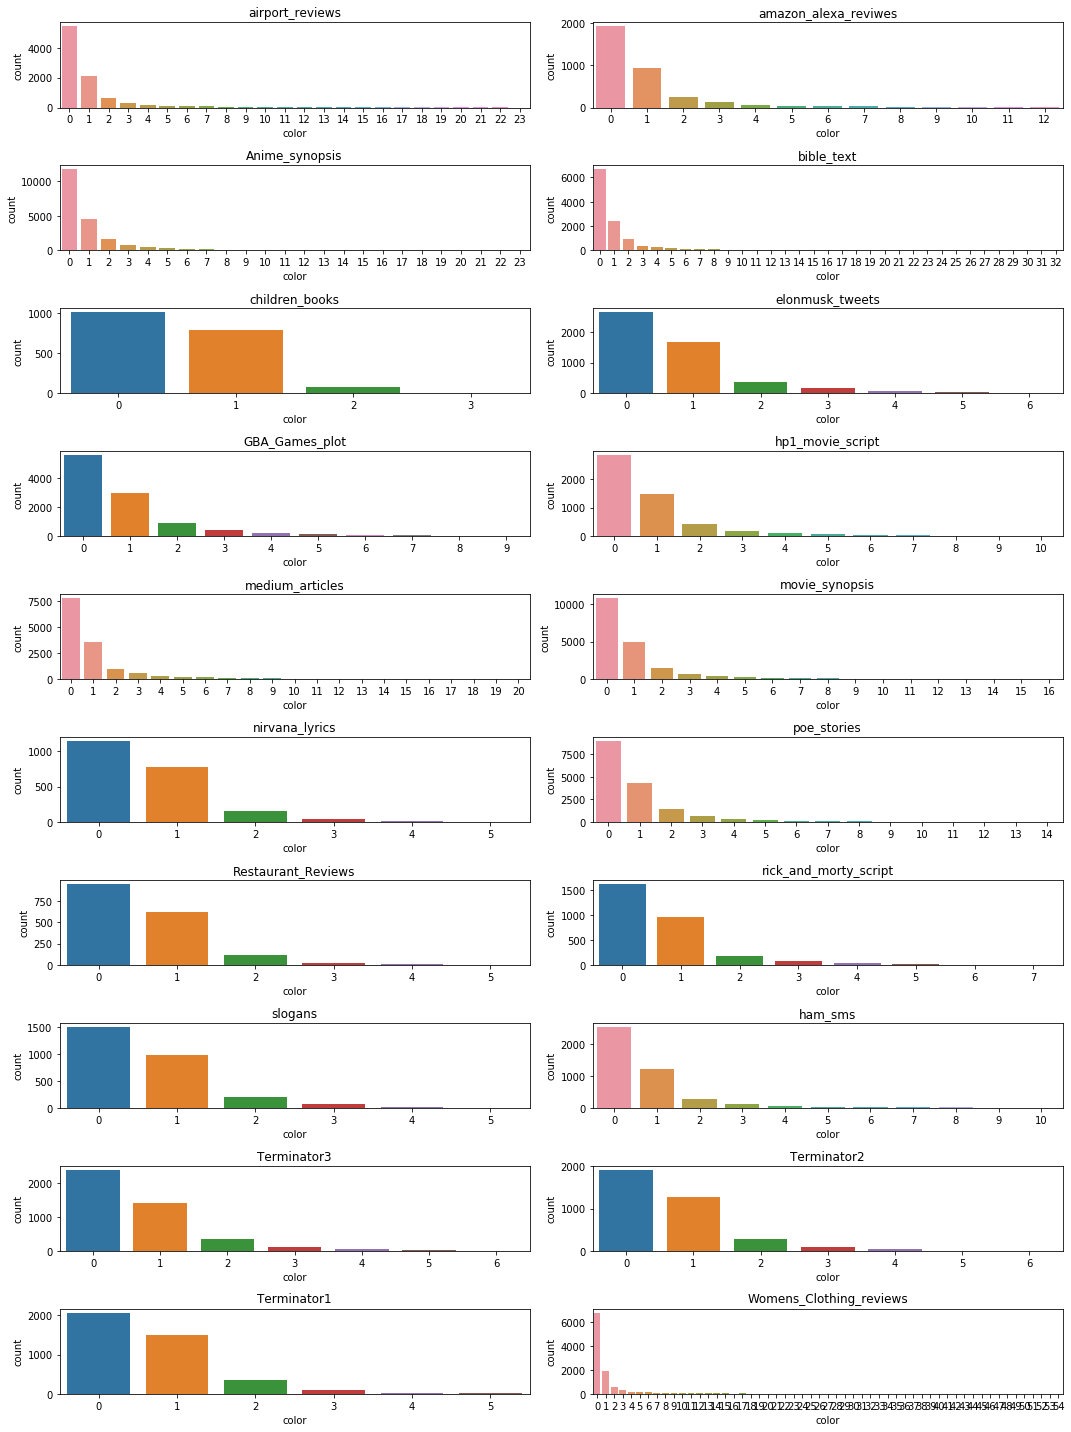

In [392]:
plt.figure(figsize=(15,20))
#plt.subtitle('Distribution of Color Tags')
for idx,graph in enumerate(bigraph_models):
    plt.subplot(10,2,idx+1)
    plt.title(graph.Name)
    sns.countplot(x=graph.Data.color)
plt.tight_layout()
plt.show()

In [393]:
'''
Question 1) Are there any connections between low count colors
Question 2) Low dimnesion representation of chromatic vector
Question 3) Is there any connection between part of speech and chromatic number
Question 4) 
'''

'\nQuestion 1) Are there any connections between low count colors\nQuestion 2) Low dimnesion representation of chromatic vector\nQuestion 3) Is there any connection between part of speech and chromatic number\nQuestion 4) \n'

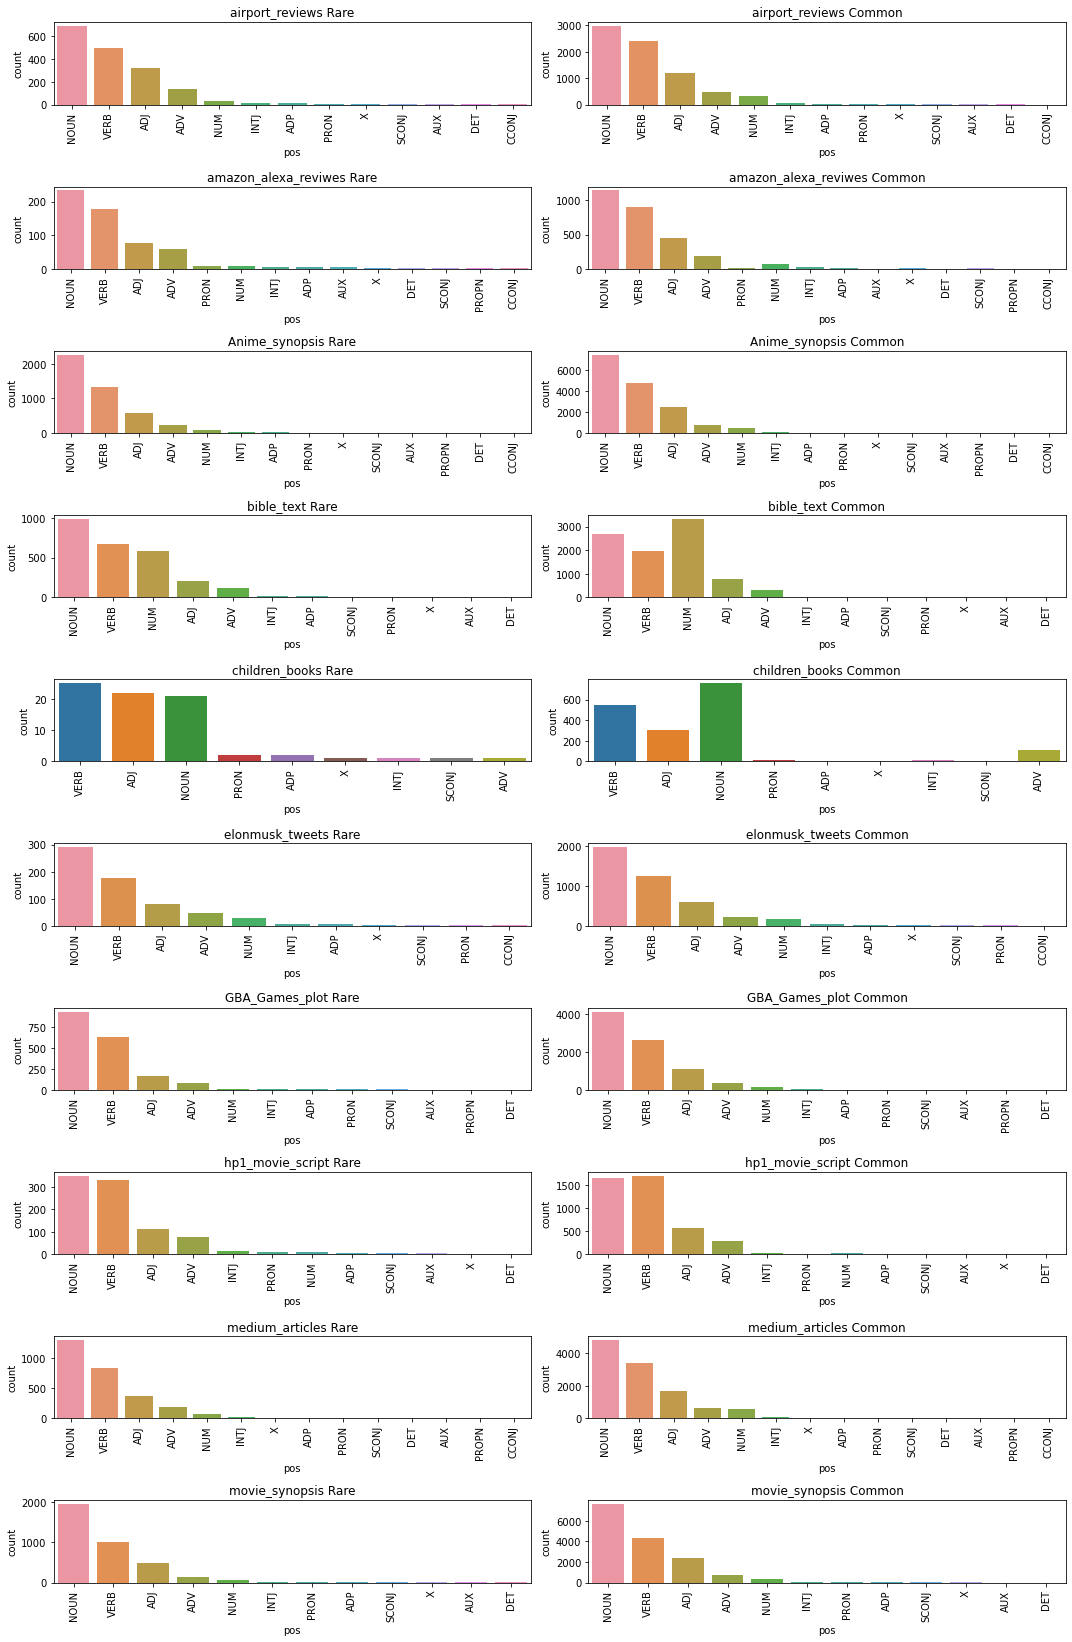

In [399]:

plt.figure(figsize=(15,45))
#plt.subtitle('Distribution of Color Tags')
for idx,graph in zip(range(1,20,2),bigraph_models):
    #calculating rare and common
    threshold = np.round(graph.Data.color.value_counts().max()*0.2)
    color_counts = graph.Data.color.value_counts()
    rare_color_counts = color_counts[color_counts<threshold]
    common_color_counts = color_counts[color_counts>threshold]

    query = ' '.join(f'color == {i} or' for i in rare_color_counts.index)
    query = query[:-3]
    rare_under_testing = graph.Data.query(query)
    rare_under_testing

    query = ' '.join(f'color == {i} or' for i in common_color_counts.index)
    query = query[:-3]
    common_under_testing = graph.Data.query(query)
    common_under_testing

    plt.subplot(20,2,idx)
    plt.title(graph.Name +' Rare')
    ax=sns.countplot(x=rare_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.subplot(20,2,idx+1)
    plt.title(graph.Name+' Common')
    ax=sns.countplot(x=common_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
plt.tight_layout()
plt.show()



In [130]:
# Claculating Text Variance
def text_variabilty(corpus):
    explained_var = 0
    N = 20
    CV=CountVectorizer()
    VECTORIZED = CV.fit_transform(corpus)
    while True:
        L_DIM = TruncatedSVD(N)
        L_DIM.fit(VECTORIZED.todense())
        explained_var = np.sum(L_DIM.explained_variance_ratio_)
        if explained_var >= 0.8:
            break
        else:
            N +=50
    return N,explained_var


In [131]:
variance_dict = dict()
for column in tqdm(multi_text.columns):
    variance_dict[column] = text_variabilty(multi_text[column][multi_text[column].notna()])

  0%|          | 0/20 [00:00<?, ?it/s]

In [479]:
# #Save variance dict
# with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_ds_variance.pkl", "wb") as file:
#     pickle.dump(variance_dict,file)

#load variance dict
with open(NFOLDER_PATH+"/multi_ds_variance.pkl", "rb") as file:
    variance_dict = pickle.load(file)

In [480]:
variance_dict

{'airport_reviews': (570, 0.8142720659834938),
 'amazon_alexa_reviwes': (270, 0.8012111418669756),
 'Anime_synopsis': (1520, 0.8006037749365807),
 'bible_text': (1220, 0.8051658761897419),
 'children_books': (70, 1.000000000000013),
 'elonmusk_tweets': (820, 0.8111496968910208),
 'GBA_Games_plot': (120, 0.8401392524381162),
 'hp1_movie_script': (570, 0.8039603176039611),
 'medium_articles': (70, 0.8575481676553128),
 'movie_synopsis': (1920, 0.8003652757969427),
 'nirvana_lyrics': (70, 0.9125791190035515),
 'poe_stories': (70, 0.9999999999999997),
 'Restaurant_Reviews': (320, 0.8187803390937398),
 'rick_and_morty_script': (370, 0.8146211654404436),
 'slogans': (170, 0.8037214393223232),
 'ham_sms': (570, 0.8032334191920281),
 'Terminator3': (970, 0.8115431487677219),
 'Terminator2': (870, 0.8084704718379417),
 'Terminator1': (1070, 0.81319901851725),
 'Womens_Clothing_reviews': (620, 0.812063153216553)}

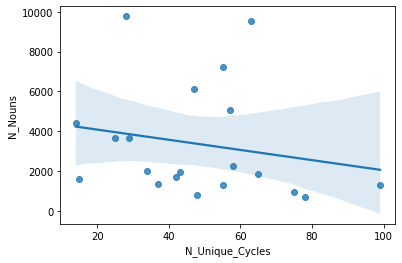

In [483]:
N_for_80_variance = [i[0] for i in list(variance_dict.values())]
chrom_nums = [i.get_Xi() for i in bigraph_models]
indeg_max = [i.In_Max_Deg for i in bigraph_models]
outdeg_max = [i.Out_Max_Deg for i in bigraph_models]
n_nouns =  [i.Data.pos.value_counts().loc['NOUN'] for i in bigraph_models]
n_verbs =  [i.Data.pos.value_counts().loc['VERB'] for i in bigraph_models]
n_nodes =  [i.Data.shape[0] for i in bigraph_models]
n_edges =  [i.N_edges for i in bigraph_models]
#n_u_cyclyes = [len(i.get_All_Unique_Cycles()) for i in bigraph_models]
#all_unique_cycles =  [len(i.get_All_Unique_Cycles()) for i in bigraph_models]

var_chrom_df = pd.DataFrame({'NComp':N_for_80_variance,'ChromN':chrom_nums,
                            'In_Max_Deg':indeg_max,'Out_Max_Deg':outdeg_max,
                            'N_Nouns':n_nouns,'N_Verbs':n_verbs,'N_Words':n_nodes,'N_Edges':n_edges,
                            'N_Unique_Cycles':n_u_cyclyes})


sns.regplot(data=var_chrom_df,x='N_Unique_Cycles',y='ChromN')
#bigraph_models[0].

<Figure size 2160x2160 with 0 Axes>

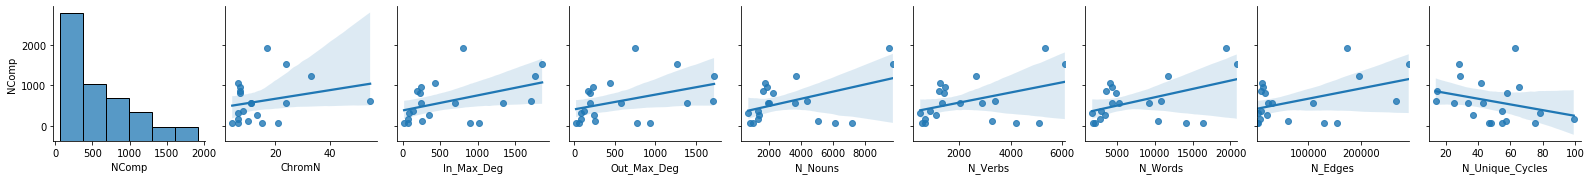

In [490]:
plt.figure(figsize=(30,30))
sns.pairplot(var_chrom_df,kind='reg',y_vars=['NComp'])

In [ ]:
#Vectorizing 
vectorized = []
for i in tqdm(example_corpus):
    vectorized.append(Bigraph.vectorize(i))


In [ ]:
pad_size = example_corpus.apply(lambda x: len(x)).max()
vec_norm = []
for vec in vectorized:
    V = np.zeros(pad_size)-1
    V[:len(vec)] = vec
    vec_norm.append(np.array(V))
vec_norm = np.array(vec_norm)    

In [ ]:
from scipy.spatial import distance_matrix

dm = distance_matrix(vec_norm,vec_norm)

In [ ]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=2,metric='cosine')

NN.fit(vec_norm)
distances, indices = NN.kneighbors(vec_norm)
NN

In [ ]:
#intersection between NN
for x,y in indices[:5]:
    INSC = set(example_corpus[x].split()) & set(example_corpus[y].split())
    print((INSC))

In [ ]:
#Cosine Distance
from scipy.spatial.distance import cosine
for x,y in indices[:5]:
    INSC = cosine(vec_norm[x,:],vec_norm[y,:])
    print((INSC))

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">New Distance Metric Using Chromatic Number</h3>


In [162]:
'''
formula = (number of identical words having the same chromatic number in both graphs) / (number of identical words in both graphs)
'''

'\nformula = (number of identical words having the same chromatic number in both graphs) / (number of identical words in both graphs)\n'

$$T_{1,2} = \text{Sets of Words in BiGramGraphs of Corpora 1 and 2}$$ 
$$ I = ||T_{1} \cap T_{2}||$$
$$ IC = ||(T_{1} \cap T_{2})  \wedge (T_{1 chrom} \cap T_{2 chrom})||$$

$$D_{chrom} = \frac{IC}{I}$$

In [646]:
def chromatic_distance(graph_1,graph_2):
    
    if 'pos' not in graph_1.Data.columns or   'pos' not in graph_2.Data.columns:
        raise PosError('Please Calculate PartofSpeech for Each Graph')
    
    overlaping_words = set(graph_1.Data['word'])
    overlaping_words = overlaping_words & set(graph_2.Data['word'])
    
    I = len(overlaping_words)
     
    chrom_ds = pd.DataFrame(index = list(overlaping_words))
    chrom_ds['chrom1'] = graph_1.Data.set_index('word').loc[overlaping_words].color
    chrom_ds['chrom2'] = graph_2.Data.set_index('word').loc[overlaping_words].color
    same_chrom_num = chrom_ds.apply(lambda x: np.mean(x) == x[0] ,axis=1)
    chrom_ds = chrom_ds[same_chrom_num].rename(columns={'chrom1':'color'}).drop(columns=['chrom2'])
    
    #Epsilon
    E = 0
    chrom_ds['weight1'] = chrom_ds.index.to_series().apply(lambda x:graph_1.Graph.degree(x) )
    #graph_1.Data.set_index('word').loc[overlaping_words].pos
    chrom_ds['weight2'] = chrom_ds.index.to_series().apply(lambda x:graph_2.Graph.degree(x) )
    #same_weight = chrom_ds.apply(lambda x: np.max(x)<=2*np.min(x) ,axis=1)
    same_weight = chrom_ds[['weight1','weight2']].apply(lambda x: np.mean(x) == x[0] ,axis=1)
    same_weight = chrom_ds[same_weight]
    
    ICW = len(same_weight)
    IC = len(chrom_ds)
    
    return ICW/I



#TO DELETE ========================

def chromatic_distance_DEC(graph_1,graph_2):
    overlaping_words = set(graph_1.Data['word'])
    overlaping_words = overlaping_words & set(graph_2.Data['word'])
    
    I = len(overlaping_words)
    
    chrom_ds = pd.DataFrame(index = list(overlaping_words))
    chrom_ds['chrom1'] = graph_1.Data.set_index('word').loc[overlaping_words].color
    chrom_ds['chrom2'] = graph_2.Data.set_index('word').loc[overlaping_words].color
    same_chrom_num = chrom_ds.apply(lambda x: np.mean(x) == x[0] ,axis=1)
    chrom_ds = chrom_ds[same_chrom_num].rename(columns={'chrom1':'color'}).drop(columns=['chrom2'])
    
    #Epsilon
    E = 0
    chrom_ds['weight1'] = chrom_ds.index.to_series().apply(lambda x:graph_1.Graph.degree(x) )
    #graph_1.Data.set_index('word').loc[overlaping_words].pos
    chrom_ds['weight2'] = chrom_ds.index.to_series().apply(lambda x:graph_2.Graph.degree(x) )
    #same_weight = chrom_ds.apply(lambda x: np.max(x)<=2*np.min(x) ,axis=1)
    same_weight = chrom_ds[['weight1','weight2']].apply(lambda x: np.mean(x) == x[0] ,axis=1)
    same_weight = chrom_ds[same_weight]
    
    ICW = len(same_weight)
    IC = len(chrom_ds)
    
    return IC,I,same_weight


In [647]:
distance_matrix = []
for i in tqdm(bigraph_models):
    row = []
    for j in bigraph_models:
        row.append(chromatic_distance(i,j))
    distance_matrix.append(row)

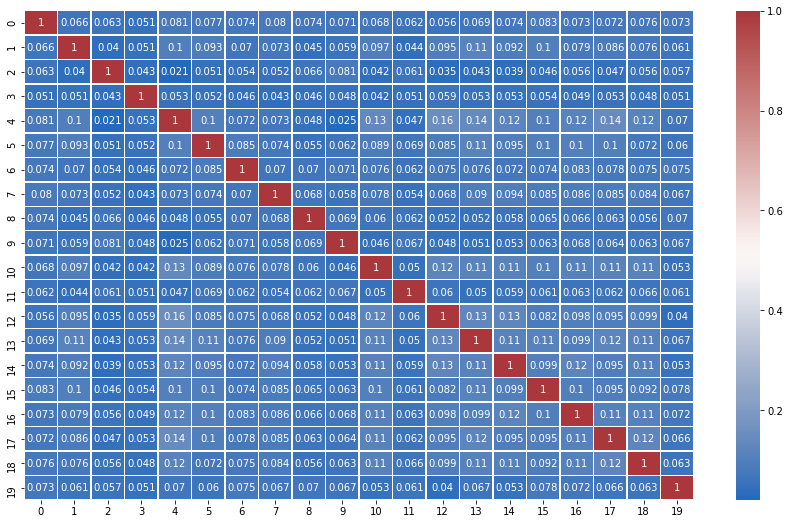

In [648]:
DM = np.array([np.array(i) for i in distance_matrix])
plt.figure(figsize=(15,9))
sns.heatmap(DM,annot=True,cmap='vlag',linewidth=0.5)
plt.show()

In [652]:
A = 17
B = 4

In [653]:
chromatic_distance(bigraph_models[A],bigraph_models[B])

0.14464534075104313

In [654]:
bigraph_models[A].Graph.degree('la')

DiDegreeView({})

In [655]:
IC,I,chrom_ds = chromatic_distance_DEC(bigraph_models[A],bigraph_models[B])

In [656]:
print('IC: ',IC)
print('I: ',I)
print('UNIQUE CHROMATIC NUMBERS: ',chrom_ds.color.unique())

IC:  298
I:  719
UNIQUE CHROMATIC NUMBERS:  [1 0 2]


In [657]:
print(bigraph_models[A],'\n Name: ',bigraph_models[A].Name)

Number of words included: 3595
Number of edges included: 10972
Chromatic number: 7
 
 Name:  Terminator2


In [658]:
print(bigraph_models[B],'\n Name: ',bigraph_models[B].Name)

Number of words included: 1864
Number of edges included: 3249
Chromatic number: 4
 
 Name:  children_books


In [683]:
chrom_ds

,color,weight1,weight2
delighted,1,2,2
interested,0,2,2
tunnel,0,2,2
sides,0,2,2
wearing,1,2,2
...,...,...,...
connected,0,2,2
friends,1,8,8
aid,1,2,2
store,0,2,2


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Paths</h3>


<h3 style="background-color:purple;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;">Missing Replacment Using Paths</h3>


In [826]:
# x1 x2 x3 nan x4 x5  --> get best path if exsits between x3 and x4

def iterative_path_search(Graph,source,target,iters=10,mode = 'minimum'):
    if mode == 'maximum':
        results = []
        max_weight =0
        GEN = Graph.get_Shortest_Simple_Path(source,target)
        for ax,i in tqdm(enumerate(GEN),leave=False):
            if ax == iters:
                break
            n_path =list( nltk.ngrams(i,2))
            c_weight = calculate_path_weight(bigraph_models[0],n_path) 
            if max_weight < c_weight:
                results = i
                max_weight = c_weight
        return results

                
    
    elif mode == 'minimum':
        results = []
        min_weight =99999
        GEN = Graph.get_Shortest_Simple_Path(source,target)
        for ax,i in tqdm(enumerate(GEN),leave=False):
            if ax == iters:
                break
            n_path =list( nltk.ngrams(i,2))
            c_weight = calculate_path_weight(bigraph_models[0],n_path) 
            if min_weight > c_weight:
                results = i
                min_weight = c_weight
        return results
        
    else:
        raise(SyntaxError())

def Bigraph_Imputer(form,Graph):
    missing_labeld = []
    start =0
    tokens = form.split(' ')
    
    for ax,word in enumerate(tokens):
        if word in ['NaN']:
            missing_labeld.append({'NaN':[start,form.find(' ',start+3)],
                                  'Prev_Word' :'' if ax == 0 else tokens[ax-1],
                                   'Next_Word' : '' if ax == len(tokens)-1 else tokens[ax+1]})
        start+=len(word)

    paths = []
    for missing in missing_labeld:
        paths.append(Graph.get_Shortest_Path(missing['Prev_Word'],missing['Next_Word']))
        
    final = form
    last_added = 0
    for path,missing in zip(paths,missing_labeld):
        start = missing['NaN']
        end   = start[1]
        start = start[0]
        final = final[:start+last_added] +' '+' '.join(path[1:-1]) + final[end+last_added:]
        last_added += (len(''.join(path[1:-1])))+1
        print(path)
            
    return final


In [814]:
bigraph_models[0].Name
multi_text['airport_reviews'][0]

'airport certainly tiny arriving good plane quick straight onto connecting bus staff information stand helpful spoke english outbound journey pleasant security zealous remove belt watch etc unfriendly bother using canteen cupboard departure lounge 1 big crush fighting fellow passengers aircraft toilets lounge filthy stinking said flight cost pizza worth putting id use'

In [810]:
test_string='airport NaN tiny arriving good plane quick NaN onto connecting bus NaN information stand helpful NaN english outbound'

In [800]:
#iterative_path_search(bigraph_models[0],'straight','staff',mode='maximum',iters=500)

In [827]:
Bigraph_Imputer(test_string,bigraph_models[0])

['airport', 'tiny']
['quick', 'straight', 'onto']
['bus', 'staff', 'information']
['helpful', 'spoke', 'english']


'airport  tiny arriving good plane qui straight onto connecting bus staffnformation stand helpful N spokelish outbound'

In [788]:
#calculate_path_weight(bigraph_models[0],list(nltk.ngrams(paths[0],2)))

In [ ]:
'''

Question 1) Heaviest Path Between Two Nodes
Question 2) Generate A Random Chromatic Vector and Generate the heaviest walk between the vector members

'''

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Random Chromatic Walk</h3>


In [528]:
class ChromaticRandomWalker:
    
    
    def __init__(self,Graph):
        self.Graph = Graph
        self.max_xi    = Graph.get_Xi()
        
    
    def __repr__(self):
        return self.Graph.__repr__()
        
    def generate_chromatic_vector(self,max_xi,size):
        chromatic_nums = list(range(max_xi))
        last_num = -1
        chrom_vec = []
        for i in range(size):
            index = np.floor((np.random.beta(1.5,1.5,1)*max_xi)[0])
            cur_choice = chromatic_nums[int(index)]
            while cur_choice == last_num:
                index = np.floor((np.random.beta(6,2,1)*max_xi)[0])
                cur_choice = chromatic_nums[int(index)]
            if cur_choice != last_num:
                last_num=cur_choice
                chrom_vec.append(cur_choice)
            else:
                continue
        self.Random_Chromatic_Vec = chrom_vec
    def calculate_path_weight(self,path):
        weight = 0
        start = path[0]
        for i in path[1:]:
            weight += self.Graph.Edges[(self.Graph.Edges['in'] == start)&(self.Graph.Edges.out == i)].weight.values[0]
            start =i
        return weight
    
    def generate(self,method='heaviest',vec_size = 5, depth=10):
        self.vec_size  = vec_size        
        self.generate_chromatic_vector(self.max_xi,self.vec_size)
        result = ' '
        first_word   = self.Graph.Data[self.Graph.Data.color==self.Random_Chromatic_Vec[0]].sample(1).word.values[0]
        for n in tqdm(self.Random_Chromatic_Vec[1:]):
            #Calculate Best Path
            paths = []
            targets = self.Graph.Data[self.Graph.Data.color==n]
            targets = targets.sample(depth if len(targets) >=depth else len(targets))
            for target in tqdm(targets.word,leave=False):
                gen = self.Graph.get_Shortest_Simple_Path(first_word,target)
                paths.append(next(gen))
            weights = np.array([self.calculate_path_weight(i) for i in paths])
            if method == 'heaviest':
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='lightest':
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            elif method =='density_max':
                weights = [calculate_path_density(self.Graph,nltk.ngrams(i,2)) for i in paths]
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='density_min':
                weights = [calculate_path_density(self.Graph,nltk.ngrams(i,2)) for i in paths]
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            del weights
            result += ' '.join(best_walk[:-1])+' '

        return result


In [542]:
RCW = ChromaticRandomWalker(bigraph_models[6])

In [543]:
RCW.generate(vec_size=15,method='density_max')

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

' powers upon power reality sends find door mounted back men tending solar gun game informs another one months time finds tied order must complete eradication mad darkness game orange star town team ray new world balance world find seaplane player eventually critically wounds awoke sounds boxers upon game different clan made world group '

In [544]:
RCW.Random_Chromatic_Vec

[5, 1, 8, 2, 5, 4, 6, 1, 6, 5, 3, 2, 0, 9, 1]

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Strongly Connected Components</h3>


In [21]:
gen = bigraph_models[16].get_Number_Strongly_Connected_Components()
bigraph_models[16].remove_self_loops()
gen = list(bigraph_models[16].get_Strongly_Connected_Components())


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Density of Nodes - Regions of High Density</h3>


In [418]:
bigraph_models[16].extract_K_Core(notebook=True)

In [472]:
N = 3

bigraph_models[N].Name

'bible_text'

In [473]:
bigraph_models[N]

Number of words included: 11741
Number of edges included: 195863
Chromatic number: 33

In [474]:
KCORE  = bigraph_models[N].extract_K_Core(notebook=True)
KCORE

Number of words included: 195
Number of edges included: 16353
Chromatic number: 33

In [475]:
print('Maximum Out Degree ',KCORE.Out_Max_Deg)
print('Maximum in Degree ',KCORE.In_Max_Deg)
print('Minimum Out Degree ',KCORE.Out_Min_Deg)
print('Minimum in Degree ',KCORE.In_Min_Deg)

Maximum Out Degree  188
Maximum in Degree  190
Minimum Out Degree  41
Minimum in Degree  42


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Design A Clustring Algorithms Based on The Graph</h3>


In [ ]:
# Using some arbitrary alpha value we decide how far can we walk from a -
#spesific node in terms of the edge weights using dikstra for example